### Data

The Dataset chosen was Brain Tumor Segmentation(BraTS2020) : https://www.kaggle.com/datasets/awsaf49/brats2020-training-data .
Given Dataset contains Brain tumour segmentation multimodal scans which are in NIfTI file format (.nii.gz) and describe different volumes like 
1. native (T1)
2. post-contrast T1-weighted (T1Gd)
3. T2-weighted (T2)
4. T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)

Tumour annotations comprise of : 
1. necrotic and non-enhancing tumor core (NCR/NET — label 1)
2. peritumoral edema (ED — label 2)
3. GD-enhancing tumor (ET — label 4)

### Formulation :
+ Each pixel must be labeled “1” if it is part of one of the classes (NCR/NET — label 1, ED — label 2, ET — label 4), and “0” if not.

### Solution
+ Unet3d will be used for automatic segmentation / mask generation.



In [ ]:
# !pip install nibabel
# !pip install pydicom
# !pip install nilearn
# !pip install albumentations==0.4.6

# Importing libraries

In [ ]:
from tqdm import tqdm
import os
import time
from random import randint
 
import gc 
import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

# !pip install albumentations==0.4.6
import albumentations as A
# from albumentations.pytorch import ToTensor, ToTensorV2


from albumentations import Compose, HorizontalFlip
# from albumentations.pytorch import ToTensor, ToTensorV2 

import warnings
warnings.simplefilter("ignore")

torch.cuda.empty_cache()

In [ ]:
import torch

print(torch.cuda.is_available())

print(torch.cuda.device_count())

(torch.cuda.current_device())

print(torch.cuda.get_device_name(0))

# Data loading

In [ ]:
# code wall time starts(cw0)
cw0 = time.time() 

# data loading time starts(dl0)
dl0 = time.time() 

In [ ]:
sample_filename = "./dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii"
sample_filename_mask = "./dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii"


sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

#load --> conversion to array --> rotate 90 

In [ ]:
sample_filename2 = './dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = './dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = './dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

# WHOLE TUOMUR / ED - LABEL 2 
mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

# NCR OR NET - LABEL 1 
mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

# ET - LABEL 4 
mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

In [ ]:
# total data loading time(dlt) 
dl1 = time.time() 
dlt = dl1 - dl0
print("Data loading time : ", dlt )

# Sample data visualization

In [ ]:
# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

# Image conversions - 2D , 3D & GIF

In [ ]:
class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """
    def __init__(self, 
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z
    
    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    
    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean
    
    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)
            
        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)
        
        return resized_data
    
    def plot_cube(self,
                  cube,
                  title: str = '', 
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
        """
        Plot 3d data.
        Parameters:
            cube: 3d data
            title: title for figure.
            init_angle: angle for image plot (from 0-360).
            make_gif: if True create gif from every 5th frames from 3d image plot.
            path_to_save: path to save GIF file.
            """
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")
            
        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()

            else:
                plt.show()

                
class ShowResult:
  
    def mask_preprocessing(self, mask):
        """
        Test.
        """
        # removing all the ones in the tensor --> using cpu --> removing the tensor from its computational graph --> tensor to numpy conversion 
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img
    
    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        
        fig, axes = plt.subplots(1, 2, figsize = (35, 30))
    
        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()
        
        plt.show()
        
#show_result = ShowResult()
#show_result.plot(data['image'], data['mask'], data['mask'])


def merging_two_gif(path1: str, path2: str, name_to_save: str):
    """
    Merging GIFs side by side.
    Parameters:
        path1: path to gif with ground truth.
        path2: path to gif with prediction.
        name_to_save: name for saving new GIF.
    """
    #https://stackoverflow.com/questions/51517685/combine-several-gif-horizontally-python
    #Create reader object for the gif
    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)

    #If they don't have the same number of frame take the shorter
    number_of_frames = min(gif1.get_length(), gif2.get_length()) 

    #Create writer object
    new_gif = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        img1 = gif1.get_next_data()
        img2 = gif2.get_next_data()
        #here is the magic
        new_image = np.hstack((img1, img2))
        new_gif.append_data(new_image)

    gif1.close()
    gif2.close()    
    new_gif.close()
    
#merging_two_gif('BraTS20_Training_001_flair_3d.gif',
#                'BraTS20_Training_001_flair_3d.gif', 
#                'result.gif')

def get_all_csv_file(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path) 
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

#csv_paths = get_all_csv_file("../input/brats20-dataset-training-validation/BraTS2020_TrainingData")

In [ ]:
class GlobalConfig:
    root_dir = './dataset'
    train_root_dir = './dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = './dataset/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = './train_data.csv'
    pretrained_model_path = './logs1/last_epoch_model.pth'
    train_logs_path = './logs1/train_log.csv'
    ae_pretrained_model_path = './logs1/best_model.pth'
    tab_data = './logs1/df_with_voxel_stats_and_latent_features.csv'
    seed = 55
    
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

# Data preprocessing

In [ ]:
# data pre-processing time starts(dpp0)
dpp0 = time.time() 

In [ ]:
survival_info_df = pd.read_csv('./dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('./dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

# renaming & merging into one dataframe

In [ ]:
paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)
    
df['path'] = paths

# config.train_root_dir = "/data/training"
# id_ = "BraTS20_Training_001"
# path = os.path.join(config.train_root_dir, id_)
# output ==> path = /data/training/BraTS20_Training_001

#split data on train, test, split
#train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=69, shuffle=True)
#train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)


In [ ]:
# Data cleaning - removing all null age entries
train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)

# Calculating Age rank for the basis of K - Fold stratification
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

len(df)

In [ ]:
# stratified k-fold ( skf ) time starts 
skf0 = time.time() 

In [ ]:
skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)

# enumeratng all entries for defining the fold number 
# assigning the fold number in increment order 
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i

In [ ]:
# total stratification time(skft) 
skf1 = time.time()
skft = skf1 - skf0 
print("Stratification time : ",skft ) 

In [ ]:
# splitting of the data wasn't done for train , test &  validation data 
train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

# selecting the rows where the AGE col. is null --> test_df 
test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)

In [ ]:
# total data pre-processing time(dppt)
dpp1 = time.time() 
dppt = dpp1 - dpp0 - skft
print("Data preprocessing time : ", dppt  ) 

In [ ]:
train_data.to_csv("train_data.csv", index=False)
test_df.to_csv("test_df.csv", index=False)
train_df.to_csv("train_df.csv", index=False)

# Dataset dataLoader

In [ ]:
class BratsDataset(Dataset):
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=False):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize
        
    def __len__(self):
        return self.df.shape[0] 
    
    def __getitem__(self, idx):
        # at a specified index ( idx ) select the value under 'Brats20ID' & asssign it to id_ 
        id_ = self.df.loc[idx, 'Brats20ID']
        
        # As we've got the id_ , now find the path of the entry by asserting the Brats20ID to id_ 
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]
        
        # load all modalities
        images = []
        
        for data_type in self.data_types:
            # here data_type is appended to the root path, as it only contains the name without the datatype such as .nii etc
            img_path = os.path.join(root_path, id_ + data_type) 
            img = self.load_img(img_path)#.transpose(2, 0, 1)
            
            if self.is_resize:
                img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)
            
        # stacking all the t1 , t1ce , t2 , t2 flair files of a single ID in a stack 
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)
            
            if self.is_resize:
                mask = self.resize(mask)
                # mask --> conversion to uint8 --> normalization / clipping ( 0 to 1 ) --> conversion to float32 
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                # again clipping ( 0 to 1 ) 
                mask = np.clip(mask, 0, 1)
            
            # setting the mask labels 1 , 2 , 4 for the mask file ( _seg.ii ) 
            mask = self.preprocess_mask_labels(mask)
    
            augmented = self.augmentations(image=img.astype(np.float32), 
                                           mask=mask.astype(np.float32))
            # Several augmentations / transformations like flipping, rotating, padding will be applied to both the images 
            img = augmented['image']
            mask = augmented['mask']
    
        
            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }
        
        return {
            "Id": id_,
            "image": img,
        }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        # normalization = (each element - min element) / ( max - min ) 
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):

        # whole tumour
        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1
        # include all tumours 

        # NCR / NET - LABEL 1
        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1
        # exclude 2 / 4 labelled tumour 
        
        # ET - LABEL 4 
        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1
        # exclude 2 / 1 labelled tumour 
        
        # ED - LABEL 2
        # mask_ED = mask.copy()
        # mask_ED[mask_ED == 1] = 0
        # mask_ED[mask_ED == 2] = 1
        # mask_ED[mask_ED == 4] = 0


        # mask = np.stack([mask_WT, mask_TC, mask_ET, mask_ED])
        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask        

In [ ]:
def get_augmentations(phase):
    list_transforms = []
    
    # Does data augmentations & tranformation required for IMAGES & MASKS 
    # they include cropping, padding, flipping , rotating 
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4 ):
    
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
        
    # selecting train_df to be all the entries EXCEPT the mentioned fold while calling dataloader 
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    
    # selection a particluar fold while calling the get_dataloader function 
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)
#     test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
#     print(len(train_df) , len(val_df), len(test_df))

    
    # read csv --> train & validation df splitting --> assigning train_df / val_df to df based on phase --> returning dataloader 
    # how does val_df / train_df got converted to ( id , image tensor , mask tensor )
    
    if phase == "train" : 
        df = train_df 
    elif phase == "valid" :
        df = val_df
#     else:
#         df = test_df
    dataset = dataset(df, phase)
    """
    DataLoader iteratively goes through every id in the df & gets all the individual tuples for individual ids & appends all of them 
    like this : 
    { id : ['BraTS20_Training_235'] ,
      image : [] , 
      tensor : [] , 
    } 
    { id : ['BraTS20_Training_236'] ,
      image : [] , 
      tensor : [] , 
    } 
    { id : ['BraTS20_Training_237'] ,
      image : [] , 
      tensor : [] , 
    } 
    """
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader

In [ ]:
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase='valid', fold=0)
len(dataloader)


In [ ]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

# batch size , channels , spatial dimensions
# no.of images in a batch : channels : t1 , t2 , flair , weighted : dimensions

In [ ]:
print(data['image'].shape)
print(data['mask'].shape)

In [ ]:
# Printing all the images & masks of "FOLD 0" --> 34 batches 
# 34 BATCHES of images & masks each batch containing 4 types of files t1 , t2 , t1ce , flair 

img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()

print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

In [ ]:
img_tensor.shape 
mask_tensor.shape

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

# Metrics and Loss metrics

In [ ]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor, 
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0] 
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        calculates using the above declare functions 
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        # appending to the respective lists 
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        # logits are the images 
        # target are the masks 
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        # binary cross entropy loss & dice loss 
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class i.e. 'WT', 'TC', 'ET'
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray, # output of the model in an array format 
               truth: np.ndarray,# masks  
               treshold: float = 0.5, # threshold to whether segment / not 
               eps: float = 1e-9, # smooth 
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    # storing all the jaccard coefficients in a list 
    
    num = probabilities.shape[0]
    
    num_classes = probabilities.shape[1]
    
    # segmenting if prob > threshold .i.e. setting to float32 
    predictions = (probabilities >= treshold).astype(np.float32)
    
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# 3DAttentionrResUnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2 with residual connection"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
        )
        self.residual = nn.Conv3d(in_channels, out_channels, kernel_size=1)  # Residual connection

    def forward(self, x):
        residual = self.residual(x)
        out = self.double_conv(x)
        out += residual  # Add the residual connection
        out = F.relu(out, inplace=True)
        return out

class AttentionBlock(nn.Module):
    """Attention Block for Attention ResUNet3D"""
    def __init__(self, in_channels):
        super().__init__()
        self.downsample = nn.Conv3d(in_channels, 1, kernel_size=1)  # Reduce channels to 1 for attention

    def forward(self, x):
        weights = torch.sigmoid(self.downsample(x))  # Calculate attention weights
        return x * weights  # Apply attention to the input feature map

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class AttentionUNet3D(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.attention1 = AttentionBlock(2 * n_channels)
        self.attention2 = AttentionBlock(4 * n_channels)
        self.attention3 = AttentionBlock(8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        x5 = self.attention3(x5)

        mask = self.dec1(x5, x4)
        mask = self.attention2(mask)

        mask = self.dec2(mask, x3)
        mask = self.attention1(mask)

        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)

        return mask

# Trainer

In [ ]:
class Trainer:
    """
    Factory for training process.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss. i.e. bce loss + dice loss / others
        optimizer: optimizer for weights updating. i.e. Adam
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases. i.e. DataLoader / dataloader
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics. -> return the jaccard coeff / dice loss
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset=dataset,
                path_to_csv=path_to_csv,
                phase=phase,
                fold=fold,
                batch_size=batch_size,
                num_workers=4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")

        # calculating the list of losses for both train & validation phases
        self.losses = {phase: [] for phase in self.phases}

        # calculating the dice scores for both train & validation phases
        self.dice_scores = {phase: [] for phase in self.phases}

        # calculating the jaccard scores for both train & validation phases
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)

        # making images predictions symmetric using logits
        logits = self.net(images)

        # calculating the loss bce loss / dice loss / jaccard loss / combined loss
        # as defined calculating the mean square error loss
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        loop = tqdm(enumerate(dataloader), total=total_batches)
        for itr, data_batch in loop:
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps

            if phase == "train":
                loss.backward()

                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

            # Update the progress bar
            loop.set_postfix(loss=running_loss / (itr + 1))

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss

    def run(self, early_stopping=False, patience=5, checkpoint_path="./checkpoints"):
        best_val_score = 0
        early_stopping_counter = 0

        for epoch in range(1, self.num_epochs+1):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                val_dice_score = self.dice_scores["val"][-1]
                print(f"BCEDiceLoss for epoch {epoch} is: ", val_loss)
                print(f"Validation dice score for epoch {epoch} is: ", val_dice_score)
                self.scheduler.step(val_loss)

            if self.display_plot:
                self._plot_train_history()

            if val_dice_score > best_val_score:
                best_val_score = val_dice_score
                early_stopping_counter = 0
                torch.save(self.net.state_dict(), os.path.join(checkpoint_path, "best_model.pth"))
            else:
                early_stopping_counter += 1
                if early_stopping and early_stopping_counter >= patience:
                    print(f"Early stopping after {epoch} epochs.")
                    break

            print()

        self._save_train_history()
        torch.cuda.empty_cache()

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"./logs2/last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("./logs2/train_log.csv", index=False)


# Training the UNet3D

In [ ]:
def objective(trial):
    # Define the search space for hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 2, 4])
    num_epochs = trial.suggest_int("num_epochs", 1, 5)
    n_channels = trial.suggest_categorical("n_channels", [8, 16, 24])
    accumulation_steps = trial.suggest_categorical("accumulation_steps", [2, 4, 6])

    # Instantiate the model and the trainer with the sampled hyperparameters
    model = AttentionUNet3D(in_channels=4, n_classes=3, n_channels=n_channels)
    trainer = Trainer(net=model,
                      dataset=BratsDataset,
                      criterion=BCEDiceLoss(),
                      lr=lr,
                      accumulation_steps=accumulation_steps,
                      batch_size=batch_size,
                      fold=0,
                      num_epochs=num_epochs,
                      path_to_csv=config.path_to_csv)

    # Train the model and get the validation score
    trainer.run(early_stopping=True, patience=5, checkpoint_path="./test_checkpoints")
    val_dice_score = trainer.dice_scores["val"][-1]

    # Return the validation score (to be minimized)
    return 1 - val_dice_score

In [ ]:
import optuna

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the objective function
study.optimize(objective, n_trials=5)

# Print the best hyperparameters and the corresponding validation score
print("Best hyperparameters: ", study.best_params)
print("Best validation dice score: ", 1 - study.best_value)

In [ ]:
if config.pretrained_model_path is not None:
    trainer.load_predtrain_model(config.pretrained_model_path)
    
    # if need - load the logs.      
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

In [ ]:
# training time(t0) starts 
t0 = time.time() 

In [ ]:
torch.cuda.empty_cache()
trainer.run()

In [ ]:
# total training time(tt) 
t1 = time.time()
tt = t1 - t0 
print("Training time : ",tt)

# Model serialization

#### A state dictionary contains only the learnable parameters.Whereas the entire model object includes the model architecture, optimizer state, and potentially other attributes. By saving only the state dictionary, you can significantly reduce the file size of the saved model.

#### Therefore i'm serializing the state dictionary of the UNET3D model

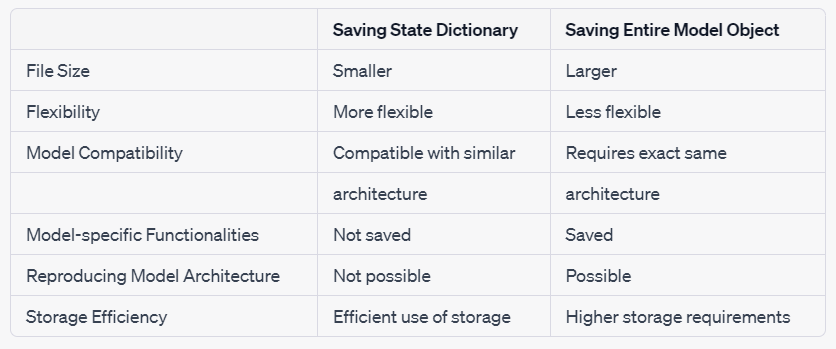

In [ ]:
torch.save(model.state_dict(), 'test_state_dict.pth')
torch.save(model, 'test_model.pth')

In [ ]:
gc.collect()

# Trainer performance evaluation

In [ ]:
# Loading the serialized model to avoid computation
model = torch.load('./test_model.pth')

# Turning on Evaluation mode of the model
model.eval()

In [ ]:
test_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='train_data.csv', phase="valid", fold=1)
len(test_dataloader)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

gc.collect() 
def compute_metrics(model, dataloader, threshold=0.33):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    counter = 0  # Counter to keep track of the number of entries processed

    with torch.no_grad():  # Disable gradient calculations to save memory
        for data in dataloader:
            
            images, targets = data['image'], data['mask']
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities >= threshold).float()

            # Compute binary segmentation metrics
            true_positives += torch.sum((predictions == 1) & (targets == 1)).item()
            false_positives += torch.sum((predictions == 1) & (targets == 0)).item()
            true_negatives += torch.sum((predictions == 0) & (targets == 0)).item()
            false_negatives += torch.sum((predictions == 0) & (targets == 1)).item()

            counter += 1

            # Free memory by clearing intermediate variables
            del images, targets, logits, probabilities, predictions
            torch.cuda.empty_cache()

    return true_positives , false_positives , true_negatives , false_negatives

tp , fp , tn , fn  = compute_metrics(model, test_dataloader, threshold=0.33)

In [ ]:
print(f"True positives : {tp}")
print(f"False positives : {fp}")
print(f"True Negatives : {tn}")
print(f"False Negatives : {fn}")

# Confusion matrix

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(tp, fp, tn, fn):
    # Create confusion matrix array
    confusion_matrix = np.array([[tn, fp], [fn, tp]])

    # Set up labels for matrix
    labels = ['True ', 'False ']

    # Create color map
    cmap = plt.cm.Blues

    # Plot confusion matrix
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Add labels to matrix cells
    thresh = confusion_matrix.max() / 2.
    for i, j in np.ndindex(confusion_matrix.shape):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'), horizontalalignment='center', color='white' if confusion_matrix[i, j] > thresh else 'black')

    # Set tick labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Set axis labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Show plot
    plt.show()

plot_confusion_matrix(tp, fp, tn, fn)


## Evaluation metrics

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [ ]:
print(f"Accuracy : {accuracy*100}")
print(f"Precision : {precision*100}")
print(f"Recall : {recall*100}")
print(f"F1 Score : {f1_score*100}")

## Classification Report

In [ ]:
# import torch
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report

# gc.collect()

# def compute_metrics(model, dataloader, num_entries, threshold=0.33):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     predictions = []

#     # Counter to keep track of the number of entries processed
#     counter = 0  

#     with torch.no_grad():
#         for data in dataloader:
#             if counter >= num_entries:
#                 break  # Stop processing entries if the desired number is reached

#             images, targets = data['image'], data['mask']
#             images = images.to(device)
#             targets = targets.to(device)

#             logits = model(images)
#             probabilities = torch.sigmoid(logits)
#             prediction = (probabilities >= threshold).float()

#             prediction =  prediction.cpu()
#             targets = targets.cpu()
            
#             predictions.append(prediction)

#             model.zero_grad()
#             del images, targets, logits, probabilities, prediction
#             torch.cuda.empty_cache()

#             counter += 1

#     # Compute confusion matrix
#     y_true = np.concatenate([targets.cpu() for data in dataloader for targets in data['mask']])
#     y_pred = np.concatenate([prediction.cpu() for data in dataloader for prediction in predictions])
    
#     # y_true = np.concatenate([targets for targets in dataloader.dataset])
#     # y_pred = np.concatenate([predictions for predictions in predictions])

    
#     cm = confusion_matrix(y_true, y_pred)
    
#     # Compute classification report
#     class_names = ['Background', 'Tumor']
#     report = classification_report(y_true, y_pred, target_names=class_names)

#     # Return evaluation metrics, confusion matrix, and classification report
#     evaluation_results = {
#         'Confusion Matrix': cm,
#         'Classification Report': report
#     }

#     return evaluation_results

# num_entries = 5  # Specify the number of entries to evaluate
# evaluation_results = compute_metrics(model, test_dataloader, num_entries, threshold=0.33)

# # Print the evaluation results
# for metric, value in evaluation_results.items():
#     print(f'{metric}: {value}')


# Experiments and Results

In [ ]:
def compute_scores_per_classes(model,          # model which is UNeT3D 
                               dataloader,     # tuple consisting of ( id , image tensor , mask tensor )
                               classes):       # classes : WT , TC , ET 
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            # Now finding the overlap between the raw prediction i.e. logit & the mask i.e. target & finding the dice & iou scores 
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            # storing both dice & iou scores in the list declared 
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes 

In [ ]:
val_dataloader = get_dataloader(BratsDataset, 'train_data.csv', phase='valid', fold=0)
len(dataloader)

In [ ]:
model.eval();

In [ ]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, val_dataloader, ['WT', 'TC', 'ET']
    )

In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
# CONCAT BOTH THE COLUMNS ALONG AXIS 1 & SORT THE TWO 
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

In [ ]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

# Computing the brain tumour segmented masks

In [ ]:
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)
            
            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()
            
            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)
            
            # only 5 pars
            if (i > 5):
                return results
        return results

In [ ]:
# prediction time starts(p0) 
p0 = time.time()

In [ ]:
results = compute_results(
    model, val_dataloader, 0.33)

In [ ]:
# total prediction time(pt) 
p1 = time.time()
pt = p1 - p0 
print("Model prediction time ; ",pt ) 

In [ ]:
for id_, img, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):
    
    print(id_)
    break

# Visualizing the predicted segmented masks

In [ ]:
show_result = ShowResult()
show_result.plot(img, gt, prediction)

# 3D SCATTER PLOT OF THE BRAIN TUMOUR WITH : 
#### 1. necrotic and non-enhancing tumor core (NCR/NET — label 1)
#### 2. peritumoral edema (ED — label 2)
#### 3. GD-enhancing tumor (ET — label 4)

In [ ]:
class ImageReader:
    def __init__(self, root:str, img_size:int=256, normalize:bool=False, single_class:bool=False):
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root
        
    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            if self.normalize:
                if frame.max() > 0:
                    frame = frame/frame.max()
                frame = frame.astype(np.float32)
            else:
                frame = frame.astype(np.uint8)
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(1*(resized['mask'] > 0) if self.single_class else resized['mask'])
        return {
            'scan': np.stack(processed_frames, 0),
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(1).zfill(3) 
        scan_filename = f'{self.root}/BraTS20_Training_{patient_id}/BraTS20_Training_{patient_id}_{scan_type}.nii'
        return self.read_file(scan_filename)
    
import plotly.graph_objects as go
import numpy as np
import plotly


def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
    def __init__(
        self, reader:ImageReader, mri_downsample:int=10, mri_colorscale:str='Ice'
    ) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale

    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        # only (1/mri_downsample) is sampled for the resulting image
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        # 1/1, 1/3 si 1/5 pixeli pentru clasele tumorii  1(nucleu necrotic), 2(edem) si 4(tumoare de amplificare)
        sampling = {
            1: 1, 2: 3, 4: 5
        }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=class_idx/4
            )
        return tumors
    def collect_patient_data(self, scan:dict) -> tuple:
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)
        return [
            generate_3d_scatter(**clean_mri, scale=self.mri_colorscale, opacity=0.3, hover='skip', name='Brain MRI'),
            generate_3d_scatter(**tumors[1], opacity=0.90, hover='all', name='Necrotic tumor core'),
            generate_3d_scatter(**tumors[2], opacity=0.05, hover='all', name='Peritumoral invaded tissue'),
            generate_3d_scatter(**tumors[4], opacity=0.30, hover='all', name='GD-enhancing tumor'),
        ], markers_created
    def get_3d_scan(self, patient_idx:int, scan_type:str='flair') -> go.Figure:
        scan = self.reader.load_patient_scan(patient_idx, scan_type)
        data, num_markers = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        fig.update_layout(
            title=f"[Patient id:{patient_idx}] brain MRI scan ({num_markers} points)",
            legend_title="Pixel class (click to enable/disable)",
            font=dict(
                family="Courier New, monospace",
                size=14,
            ),
            margin=dict(
                l=0,r=0,b=0,t=30
            ),
            legend=dict(itemsizing='constant')
        )
        return fig

# tumour visualization time starts(tv0)
tv0 = time.time() 
reader = ImageReader(config.train_root_dir, img_size=128, normalize=True, single_class=False)
viewer = ImageViewer3d(reader, mri_downsample=25)

fig = viewer.get_3d_scan(250, 'flair')
plotly.offline.iplot(fig)

In [ ]:
# total tumour visualization time(tvt) 
tv1 = time.time() 
tvt = tv1 - tv0 
print("3D Scatter plot time : ", tvt ) 

In [ ]:
import plotly.offline as pyo
import plotly.graph_objects as go

# Save the scatter plot as an image file
filename = './scatter_plot_test.png'  # Replace with your desired file path
pyo.plot(fig, filename=filename, auto_open=False)

In [ ]:
# total code wall time(cwt)
cw1 = time.time() 
cwt = cw1 - cw0 
print("Total code wall time / running time : ", cwt )

# Code running time evalution 

In [ ]:
from tabulate import tabulate

# Define the variables and their respective values
variables = ['Data loading', 'data preprocessing', 'Stratification', 'Model training', 'tumour predction', 'tumour visualization', ' total code wall time']
values = [dlt, dppt, skft, tt, pt, tvt, cwt]  # Assign the actual values to these variables

# Create a list of lists containing the variables and values
table_data = [[var, val] for var, val in zip(variables, values)]

# Specify the table headers
headers = ['Times', 'Value']

# Generate the table using tabulate
table = tabulate(table_data, headers, tablefmt='grid')

# Print the table
print(table)


In [ ]:
import matplotlib.pyplot as plt

# Define the variables and their respective values (running times)
variables = ['Data loading', 'data preprocessing', 'Stratification', 'Model training', 'tumour predction', 'tumour visualization', ' total code wall time']
values = [dlt, dppt, skft, tt, pt, tvt, cwt]  # Assign the actual running times to these variables

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(variables, values)  # Plot the bar chart

# Add labels and title
plt.xlabel('Variables')  # X-axis label
plt.ylabel('Running Time')  # Y-axis label
plt.title('Running Times of Variables')  # Chart title

# Display the bar chart
plt.show()
